In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [60]:
from tqdm.auto import tqdm
from rl_analysis.plotting import (
    setup_plotting_env,
    clean_ticks,
    savefig,
)
from rl_analysis.io.df import get_closed_loop_parquet_columns
from rl_analysis.util import rle, whiten

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

## Load in pre-processed data

In [10]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [11]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
closed_loop_cfg = analysis_config["closed_loop_behavior"]
figure_cfg = analysis_config["figures"]

In [12]:
force = False

In [13]:
results_file = os.path.join(
    proc_dirs["closed_loop_behavior"], "realtime_effects_kinematics.parquet"
)

In [14]:
npcs = 10
fname = os.path.join(raw_dirs["closed_loop_behavior"], "closed_loop_behavior.parquet")
cols = get_closed_loop_parquet_columns(fname, pcs=True, likes=False)

In [15]:
feedback_df = pd.read_parquet(
    fname,
    filters=[
        (
            "experiment_type",
            "in",
            [
                "reinforcement",
            ],
        ),
    ],
    columns=cols,
).sort_index()

In [16]:
feedback_df = feedback_df.loc[feedback_df["session_number"].isin([-1, 0, 1, 2])].copy()

In [17]:
feedback_df = feedback_df.loc[
    (feedback_df["area"].isin(["snc (axon)", "ctrl"]))
    & (feedback_df["opsin"].isin(["chr2", "ctrl"]))
].copy()

In [18]:
feedback_df["predicted_syllable"] = feedback_df["predicted_syllable"].astype("Int8")
feedback_df.loc[feedback_df["predicted_syllable"] < 0, "predicted_syllable"] = np.nan
feedback_df["predicted_syllable"] = feedback_df.groupby("uuid")[
    "predicted_syllable"
].fillna(method="ffill", limit=10)

feedback_df.dropna(subset=["predicted_syllable"], inplace=True)
feedback_df.rename(columns={"predicted_syllable": "syllable"}, inplace=True)

In [19]:
feedback_df["syllable"] = feedback_df["syllable"].astype("int8")

codes, uniqs = pd.factorize(
    list(zip(feedback_df["uuid"], feedback_df["session_number"]))
)
feedback_df["uniq_id"] = codes

# syllable number
feedback_df["syllable_number"] = feedback_df.groupby("uniq_id")["syllable"].transform(
    lambda x: (x.diff() != 0).cumsum()
)
feedback_df.loc[
    feedback_df["session_number"].isin([-1, 0, 3, 4]), "feedback_status"
] = -1

In [20]:
# map onto win's features
feedback_df["acceleration_3d_mm"] = feedback_df.groupby("uuid")[
    "velocity_3d_mm"
].transform(lambda x: x.diff(2))
feedback_df["acceleration_2d_mm"] = feedback_df.groupby("uuid")[
    "velocity_2d_mm"
].transform(lambda x: x.diff(2))
feedback_df["angle"] = feedback_df.groupby("uuid")["angle"].apply(
    lambda x: x.interpolate(method="linear", limit=30)
)
feedback_df["angle_unwrapped"] = feedback_df.groupby("uuid")["angle"].transform(
    np.unwrap
)
feedback_df["velocity_angle"] = feedback_df.groupby("uuid")[
    "angle_unwrapped"
].transform(lambda x: x.diff(2))
feedback_df["velocity_height"] = feedback_df.groupby("uuid")["height_ave_mm"].transform(
    lambda x: x.diff(2)
)

/tmp/ipykernel_1560979/2098227803.py:8: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  feedback_df["angle"] = feedback_df.groupby("uuid")["angle"].apply(


# Cram down into an RLE dataframe for quick slicing/dicing

In [21]:
feedback_df = feedback_df.loc[feedback_df["session_number"].isin([1, 2])].copy()

In [22]:
feedback_df["is_feedback"] = (feedback_df["feedback_status"] > 0) & (
    feedback_df["session_number"].isin([1, 2])
)
feedback_df["is_catch"] = (feedback_df["feedback_status"] == 0) & (
    feedback_df["session_number"].isin([1, 2])
)
is_feedback = feedback_df.groupby(["uuid", "syllable_number"])["is_feedback"].any()
is_catch = feedback_df.groupby(["uuid", "syllable_number"])["is_catch"].any()

In [23]:
rle_df = feedback_df.groupby("uuid")["syllable"].apply(rle)
rle_df.index = rle_df.index.droplevel(0)
rle_df = feedback_df.loc[rle_df.index]
rle_df = rle_df.set_index(["uuid", "syllable_number"])

In [24]:
pc_columns = feedback_df.filter(regex="pc0[0-9]$").columns.tolist()
pc_columns_z = [f"{_}_z" for _ in pc_columns]
feedback_df[pc_columns_z] = feedback_df.groupby("uuid")[pc_columns].transform(
    lambda x: (x - x.mean()) / x.std()
)

In [25]:
pc_columns = feedback_df.filter(regex="pc0[0-9]").columns.tolist()
pc_stats = feedback_df.groupby(["uuid", "syllable_number"])[
    sorted(list(set(pc_columns + pc_columns_z)))
].agg(["mean", "var"])
pc_stats.columns = ["_".join(_) for _ in pc_stats.columns]

In [26]:
rle_df.drop(
    ["is_feedback", "is_catch"] + pc_stats.columns.tolist(),
    axis=1,
    errors="ignore",
    inplace=True,
)

In [27]:
def assign_random_feedbacks(x, catch_prob=0.25):
    # given a vector of values, assign 1-catch to 1 and catch to 2
    feedback_vec = np.ones((len(x),), dtype="int") * 2
    feedback_series = pd.Series(data=feedback_vec, index=x.index)
    fbacks = np.random.choice(
        np.arange(len(x)), size=np.round(len(x) * (1 - catch_prob)).astype("int")
    )
    feedback_series.iloc[fbacks] = 1
    return feedback_series

In [28]:
tqdm.pandas()

In [29]:
rle_df["random_feedback_status"] = rle_df.groupby(["uuid", "syllable"])[
    "syllable"
].progress_transform(assign_random_feedbacks)

  0%|          | 0/21381 [00:00<?, ?it/s]

In [30]:
rle_df = rle_df.sort_index()
is_feedback = is_feedback.sort_index()
is_catch = is_catch.sort_index()
pc_stats = pc_stats.sort_index()

In [31]:
test = pd.concat([rle_df, is_feedback, is_catch, pc_stats], axis=1)

In [32]:
test["feedback_status"] = test["is_feedback"].astype("int")
test.loc[test["is_catch"], "feedback_status"] = 2

In [33]:
check_columns = pc_stats.columns

In [34]:
check_columns = [_ for _ in pc_stats.columns if "_z" in _]

## Build a classifier from some simple averages

In [42]:
test["mouse_id"] = test["mouse_id"].astype("str")
test["area"] = test["area"].astype("str")

In [43]:
from scipy.stats import zscore

In [44]:
test.loc[test["mouse_id"].str.contains("ai32jr"), "area"] = "snc (axon)"
test.loc[test["mouse_id"].str.contains("chrimson"), "area"] = "snc (axon, chrimson)"

In [45]:
use_agg_data = (
    test.loc[test["syllable"] == test["target_syllable"]]
    .groupby(
        [
            "area",
            "stim_duration",
            "mouse_id",
            "session_number",
            "opsin",
            "target_syllable",
            "feedback_status",
        ]
    )[check_columns]
    .mean()
)
use_agg_data = use_agg_data.loc[:, ~use_agg_data.columns.duplicated()]

# get down to stim v catch
y = use_agg_data.index.get_level_values("feedback_status")
use_agg_data = use_agg_data.loc[y > 0]

In [46]:
use_agg_data_z = use_agg_data.groupby(["target_syllable"]).transform(zscore)

In [47]:
y = {}
x = {}

In [48]:
use_data_z = use_agg_data_z.dropna().xs(
    ("snc (axon)", 0.25), level=("area", "stim_duration")
)
use_data = use_agg_data.dropna().xs(
    ("snc (axon)", 0.25), level=("area", "stim_duration")
)

y["target_syllable"] = use_data.index.get_level_values("target_syllable").values.ravel()
y["feedback_status"] = use_data_z.index.get_level_values(
    "feedback_status"
).values.ravel()

In [49]:
x["target_syllable"] = whiten(use_data.values)[0]
x["feedback_status"] = whiten(use_data_z.values)[0]

In [50]:
from sklearn import (
    discriminant_analysis,
    model_selection,
    ensemble,
    metrics,
)
from sklearn.base import clone
from scipy.stats import zscore

In [51]:
clf = discriminant_analysis.LinearDiscriminantAnalysis()

In [52]:
n_folds = 5
splits = model_selection.RepeatedStratifiedKFold(
    n_splits=n_folds, n_repeats=20, random_state=0
)

In [53]:
from collections import defaultdict
perf = defaultdict(list)

In [54]:
for k, v in tqdm(y.items()):
    for train_idx, test_idx in tqdm(splits.split(x[k], v)):
        clf = clone(clf)
        x_train, x_test = zscore(x[k][train_idx]), zscore(x[k][test_idx])
        y_train, y_test = v[train_idx], v[test_idx]
        clf.fit(x_train, y_train)
        perf[k].append(metrics.accuracy_score(y_test, clf.predict(x_test)))

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [55]:
for k, v in perf.items():
    perf[k] = np.array(v).reshape(-1, n_folds)

In [56]:
nshuffles = 1000

In [57]:
mean_perfs = defaultdict(list)
rng = np.random.default_rng(0)
for k, v in tqdm(y.items()):
    for _shuffle in tqdm(range(nshuffles)):

        shuffle_perfs = []

        for train_idx, test_idx in splits.split(x[k], v):

            # clf = clone(clf)
            x_train, x_test = zscore(x[k][train_idx]), zscore(x[k][test_idx])
            y_train, y_test = v[train_idx], v[test_idx]
            x_train = x_train[rng.permutation(np.arange(len(x_train)))]
            clf.fit(x_train, y_train)
            shuffle_perfs.append(metrics.accuracy_score(y_test, clf.predict(x_test)))

        mean_perfs[k].append(np.array(shuffle_perfs).reshape(-1, n_folds).mean(axis=1))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [58]:
for k, v in mean_perfs.items():
    mean_perfs[k] = np.concatenate(v)

In [61]:
setup_plotting_env()

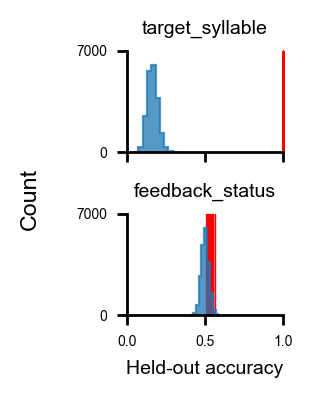

In [63]:
fig, ax = plt.subplots(2, 1, figsize=(1.5, 2), sharex=True, sharey=True)
for _ax, k in zip(ax, mean_perfs.keys()):
    (hist_handle,) = _ax.hist(
        mean_perfs[k], histtype="step", density=False, fill=True, alpha=0.75
    )[2]

    for _perf in perf[k].reshape(-1, n_folds).mean(axis=1):
        line_handle = _ax.axvline(
            x=_perf, color="r", lw=0.5, zorder=-300, clip_on=False
        )
    _ax.set_title(k, fontsize=7)

clean_ticks(ax[0], "y", precision=-3, dtype=int)
plt.xlim(0, 1.0)
plt.xlabel("Held-out accuracy")
fig.supylabel("Count")
sns.despine()
fig.tight_layout()
savefig(
    fig,
    os.path.join(figure_cfg["store_dir"], "realtime_pc_kinematic_classifier"),
    bbox_inches="tight",
)

In [64]:
conditions = perf.keys()

In [65]:
stats = {}

In [66]:
for _condition in conditions:
    stats[_condition] = {}
    z = perf[_condition].mean() - mean_perfs[_condition].mean()
    z /= np.sqrt(perf[_condition].std() * mean_perfs[_condition].std())
    stats[_condition]["pval"] = (
        perf[_condition].mean() < mean_perfs[_condition]
    ).mean()
    stats[_condition]["stat"] = z
    stats[_condition]["stat_definition"] = "standardized mean difference"
    stats[_condition]["test"] = "shuffle_test"

In [68]:
import json

In [69]:
with open(
    os.path.join(
        proc_dirs["closed_loop_behavior"], "stats_stim_kinematic_classifier.toml"
    ),
    "w",
) as f:
    toml.dump(json.loads(json.dumps(stats)), f)